# Monet GAN Mini-Project

##  Problem Definition
This is a project to use Kaggle's "I'm Something of a Painter Myself" competition to do exploratory data analysis (EDA), model building and training, and comparison with deep learning. 
In this case, the technique we will be exploring are **GANs**. A GAN is a generative adversarial network that consists of at least two neural networks. The generator creates images and the discriminator tries to accurately classify them. 

Information about the competition can be found at https://www.kaggle.com/competitions/gan-getting-started/overview.
The goal is to build a GAN that generates images in the style of Monet that can trick classifiers into believing the images are created by Monet.

### Dataset Information
The data is from the Kaggle competition. I need to output 7000-10000 images sized 256x256. The dataset contains:
- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format
The monet_tfrec and monet_jpg directories contain the same painting images from Monet, and the photo_tfrec and photo_jpg directories contain the same photos that need to have Monet-style added.


Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import PIL
import shutil

In [2]:
monet_filenames = tf.io.gfile.glob('../input/gan-getting-started/monet_tfrec/*.tfrec')
photo_filenames = tf.io.gfile.glob('../input/gan-getting-started/photo_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(monet_filenames))
print('Photo TFRecord Files:', len(photo_filenames))

# Set up tensorflow
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.experimental.AUTOTUNE

Monet TFRecord Files: 5
Photo TFRecord Files: 20
Number of replicas: 1


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
I will view the data and determine if it needs cleaning or other handling. I will also visualize the data to form a plan of analysis.
The images are already sized to 256x256. The images are RBG, so the channel needs to be 3. The images also need to be scaled to [-1, 1]. We don't need the labels or image ID for a generative model.

In [3]:
# Let's read in the images and format them as required
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

#define function to extract image
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [4]:
monet_ds = load_dataset(monet_filenames, labeled=True).batch(1, drop_remainder=True)
photo_ds = load_dataset(photo_filenames, labeled=True).batch(1, drop_remainder=True)

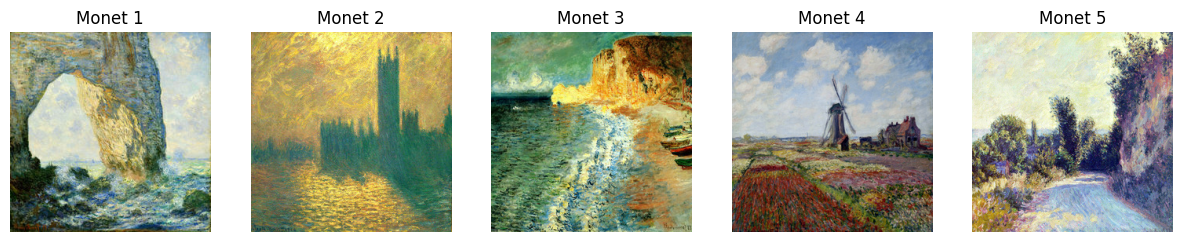

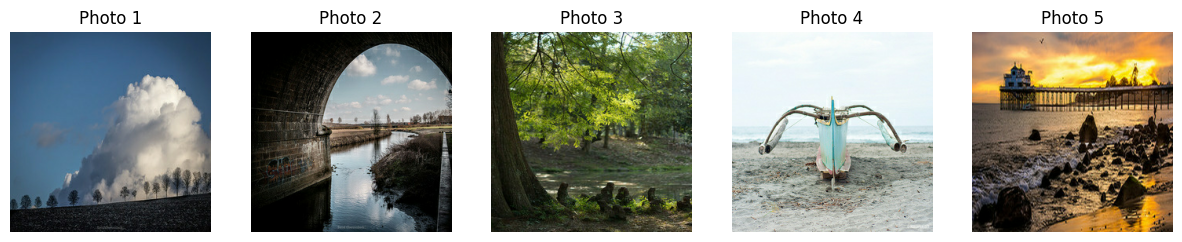

In [5]:
# View some of the images
def display_images(dataset, title, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(dataset.take(num_images)):  # Only iterate over images
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[0]*0.5+0.5)  # The image is batched, so we access the first element. Need to convert to 0, 1 for imshow
        plt.title(f'{title} {i + 1}')
        plt.axis('off')
    plt.show()

# Preview 5 Monet images
display_images(monet_ds, 'Monet', num_images=5)

# Preview 5 Photo images
display_images(photo_ds, 'Photo', num_images=5)

Looks like the images are labeled correctly. I'd like to see the difference between the pixel intensities and color channels of the regular photos vs Monet. I think that's probably a major differentiator. 

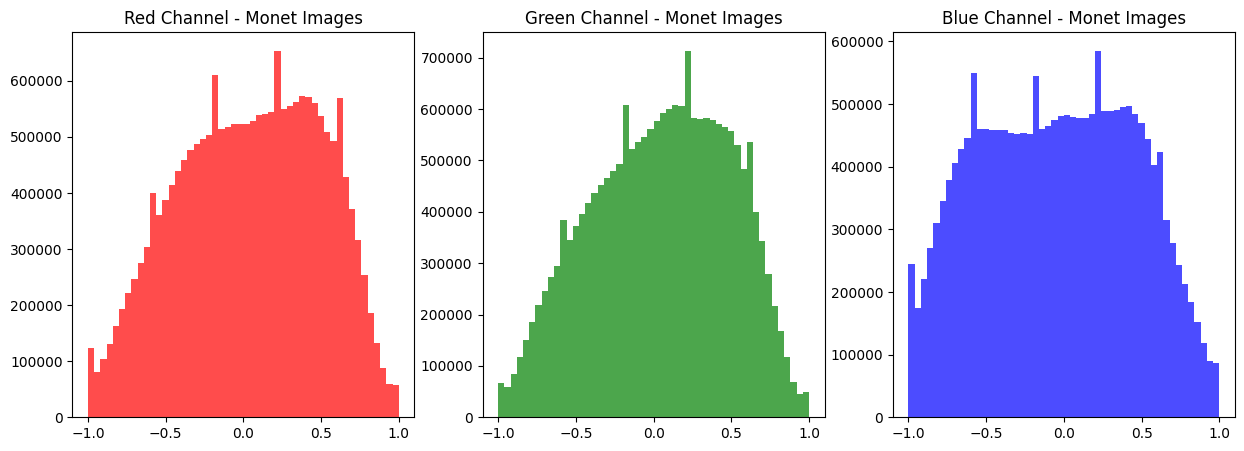

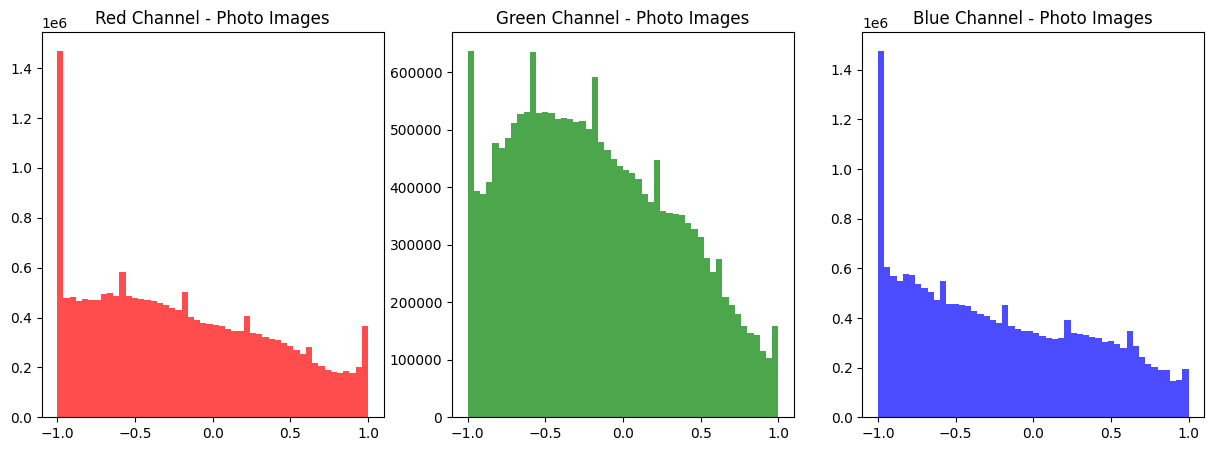

In [6]:
# Function to extract pixel values and compute histograms
def get_image_data(dataset, num_images=100):
    """ Extract pixel values from the dataset and return them as a list. """
    image_data = []
    for image in dataset.take(num_images):
        image = image[0]  # Take the image from the batch
        image_data.append(image.numpy())  # Convert to numpy array
    return np.array(image_data)

# Function to plot histograms for each channel
def plot_color_histogram(image_data, title, bins=50):
    """ Plot histograms of pixel intensities for each RGB channel. """
    # Flatten the pixel data by separating channels
    red_channel = image_data[:, :, :, 0].flatten()  # Red channel
    green_channel = image_data[:, :, :, 1].flatten()  # Green channel
    blue_channel = image_data[:, :, :, 2].flatten()  # Blue channel
    
    # Plot histograms for each color channel
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(red_channel, bins=bins, color='red', alpha=0.7)
    plt.title(f'Red Channel - {title}')
    
    plt.subplot(1, 3, 2)
    plt.hist(green_channel, bins=bins, color='green', alpha=0.7)
    plt.title(f'Green Channel - {title}')
    
    plt.subplot(1, 3, 3)
    plt.hist(blue_channel, bins=bins, color='blue', alpha=0.7)
    plt.title(f'Blue Channel - {title}')
    
    plt.show()

# Load and process Monet dataset
monet_images = get_image_data(monet_ds, num_images=300)  # Going to use all the paintings
plot_color_histogram(monet_images, "Monet Images")

# Load and process Photo dataset
photo_images = get_image_data(photo_ds, num_images=300)  # Use 300 images for the histogram
plot_color_histogram(photo_images, "Photo Images")

The color channels and intensities are significantly different for the red and blue channels. The distributions are skewed in opposite directions for the green channel, but the overall intensity is somewhat comparable. I think red and blue will be the most important change in the non-Monet photos.
I don't know if class imbalance will be a problem here or not. There are only 300 Monet images to train on and 7000 images to style. I'm going to keep the imbalance as it is and see if I need to reconsider it after testing the model.

## Model Architecture
This excercise is specifically to see how well a GAN performs. I'm going to use a CycleGAN, where images are downsampled to extract features and then upsampled to generate higher-resolution output. 

In [7]:
# Function to create a downsampling block
def downsample(filters, size, apply_batchnorm=True):
    """ 
    Creates a downsampling layer using Conv2D.
    Arguments:
    - filters: Number of filters in the convolution.
    - size: Size of the convolutional filter (kernel size).
    - apply_batchnorm: Whether to apply Batch Normalization.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
               kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    result.add(layers.ReLU())

    return result

# Function to create an upsampling block
def upsample(filters, size, apply_batchnorm=True):
    """ 
    Creates an upsampling layer using Conv2DTranspose.
    Arguments:
    - filters: Number of filters in the transposed convolution.
    - size: Size of the transposed convolution filter (kernel size).
    - apply_batchnorm: Whether to apply Batch Normalization.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                        kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    result.add(layers.ReLU())

    return result


Now we can create the generator architecture. I'm going to use the example provided by Amy Jang, where the generator first downsamples the input image and then upsamples while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [8]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4), # (bs, 2, 2, 1024)
        upsample(512, 4), # (bs, 4, 4, 1024)
        upsample(512, 4), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Now we need to make a discriminator to determine if a photo is Monet or not. Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher values indicating a real classification and lower values indicating a fake classification.

In [9]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [10]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

Now we can build the CycleGAN model. During training the model will transform a photo to a Monet painting and then back to a photo. The difference between them is the cycle-consistency loss. The original photo and the twice-transformed photo should be similar to eachother. 

In [11]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Now we need some loss functions. The image is either Monet or not, so it's a binary classification.

In [12]:
# The perfect discriminator will ouput all 1s for real images and all 0s for fake images
# The output is the average of the real and generated loss
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    # The perfect generator will have the discriminator only output 1s.
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

    # Checks if the original phooto and twice transformed photo are similar to eachother (their average difference)
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

    # Compares the image with its generator
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

Now we can compile and train the model. For results/analysis purposes I'll make a custom callback so that I can plot the loss later.

In [13]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

    # Fit the model with the loss tracking callback
    cycle_gan_model.fit(
        tf.data.Dataset.zip((monet_ds, photo_ds)), steps_per_epoch=200,
        epochs=15
    )

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 201s 899ms/step - monet_disc_loss: 0.6609 - monet_gen_loss: 7.5046 - photo_disc_loss: 0.6468 - photo_gen_loss: 7.7646
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 447ms/step - monet_disc_loss: 0.6734 - monet_gen_loss: 5.6978 - photo_disc_loss: 0.6030 - photo_gen_loss: 5.9060 
Epoch 3/15


C:\Users\greyx\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 179s 897ms/step - monet_disc_loss: 0.6431 - monet_gen_loss: 6.6217 - photo_disc_loss: 0.5654 - photo_gen_loss: 7.0004
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 446ms/step - monet_disc_loss: 0.6425 - monet_gen_loss: 5.2972 - photo_disc_loss: 0.5659 - photo_gen_loss: 5.4040 
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 179s 896ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 6.2808 - photo_disc_loss: 0.5619 - photo_gen_loss: 6.6117
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 446ms/step - monet_disc_loss: 0.7034 - monet_gen_loss: 5.5192 - photo_disc_loss: 0.6288 - photo_gen_loss: 5.4403 
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 179s 896ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 5.9653 - photo_disc_loss: 0.5528 - photo_gen_loss: 6.2660
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 446ms/step - monet_disc_loss: 0.6852 - monet_gen_loss: 5.6919 - photo_disc_loss: 0.4608 - photo_gen_loss: 5.7976 
Epoch 9/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 179s 896ms/step - monet

## Results and Analysis
Let's see what the results look like and determine if they need improving.

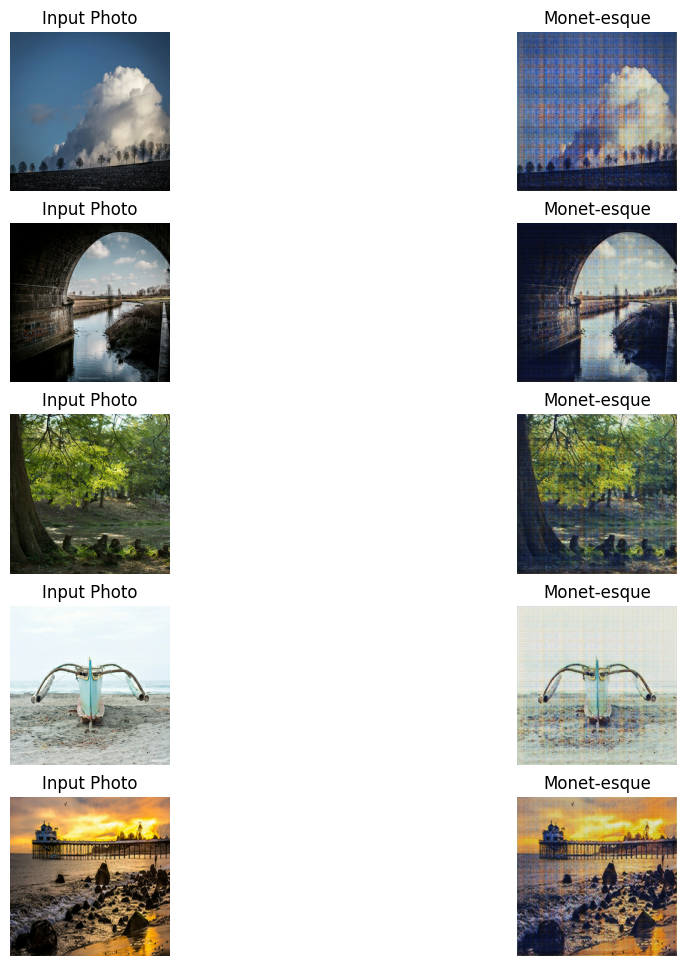

In [14]:
# Visualize the transformed photos
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

The results aren't great. I think it's getting part of the way there but it looks unnatural/mechanical, like I can directly tell one type of filter is being applied. Maybe I could randomize some of the training data. Maybe I should lower the weight of the cycle consistency loss, or add noise to the generators input. It might also benefit from being tested on more epochs. 

I need to create a submission file for Kaggle to find out how the model did versus their MiFID (Memorization-informed Fréchet Inception Distance) evaluation. It's basically the distance between the real and generated images, so a smaller MiFID is better. More information about MiFID is available on the Kaggle overview page.

In [15]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

shutil.make_archive("../working/images", 'zip', "/kaggle/images")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/images'

## Conclusion
The CycleGAN is partially Monet-izing the sample images. The blurryness and color profiles are certainly stepping closer to being like a Monet painting, but are still very far from being convincing. I think the model could be improved with randomizing of the training data and maybe the addition of noise to the generator input. I could probably also mess with the loss weights and learning rates. As for the Kaggle rating based on MiFID, my score was .69.

## References
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial